# Necessary Steps

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
from random import choice
import re
import csv
import pandas as pd
import glob
import math
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon

from ultralytics import YOLO
from PIL import Image


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
cd /content/drive/MyDrive/Pond/YoLoV11/Plantations

/content/drive/MyDrive/Pond/YoLoV11/Plantations


In [5]:
pwd = os.getcwd()
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Plantations'

# Roboflow Download Data

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Plantations'

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xi0GmSwVPwJmrIJu9U9m")
project = rf.workspace("pond-p90hl").project("plantations-lox6q")
version = project.version(2)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Plantations-2 in yolov11:: 100%|██████████| 1467/1467 [00:09<00:00, 158.62it/s]


# Visualize

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Plantations'

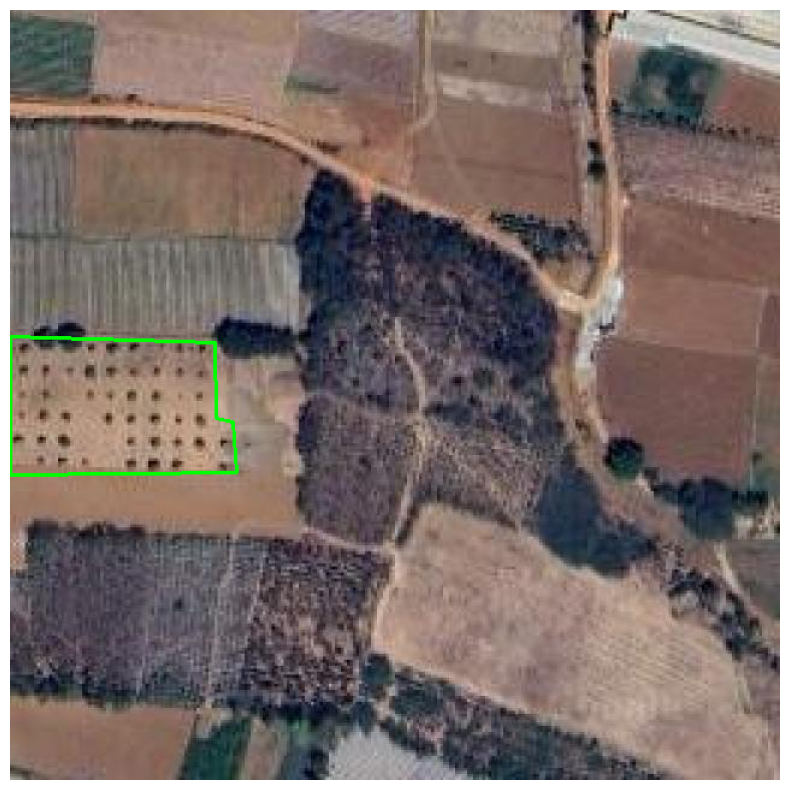

In [ ]:
annotation_file_path = "data/train/labels/tile_17_94036_60687_png.rf.8353ffbfd11e1b3c551f624ddd5ac921.txt"
annotation_file_path = os.path.join(pwd, annotation_file_path)
image_file_path = "data/train/images/tile_17_94036_60687_png.rf.8353ffbfd11e1b3c551f624ddd5ac921.jpg"
image_file_path = os.path.join(pwd, image_file_path)

# Check if the files exist
if not os.path.exists(image_file_path):
    raise FileNotFoundError(f"Image file not found: {image_file_path}")
if not os.path.exists(annotation_file_path):
    raise FileNotFoundError(f"Annotation file not found: {annotation_file_path}")

# Read the image
image = cv2.imread(image_file_path)
if image is None:
    raise ValueError(f"Failed to read image from file: {image_file_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the image dimensions
image_height, image_width = image.shape[:2]

# Read the annotation file
with open(annotation_file_path, 'r') as f:
    annotations = f.readlines()

# Define a function to draw polygons on the image
def draw_polygons(image, annotations, img_width, img_height):
    for annotation in annotations:
        parts = annotation.strip().split()
        class_index = int(parts[0])
        points = list(map(float, parts[1:]))
        # Scale the normalized coordinates to the image dimensions
        scaled_points = [int(points[i] * img_width if i % 2 == 0 else points[i] * img_height) for i in range(len(points))]
        # Create a list of (x, y) tuples
        polygon = [(scaled_points[i], scaled_points[i+1]) for i in range(0, len(scaled_points), 2)]
        polygon = np.array(polygon, np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        # Draw the polygon on the image
        cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
    return image

# Draw the annotations on the image
image_with_annotations = draw_polygons(image, annotations, image_width, image_height)

# Display the image with annotations
plt.figure(figsize=(10, 10))
plt.imshow(image_with_annotations)
plt.axis('off')
plt.show()

# Model Training

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Plantations'

In [ ]:
# Load a model
model = YOLO("yolo11x-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11x-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11x-seg.yaml").load("yolo11x.pt")  # build from YAML and transfer weights

100%|██████████| 119M/119M [00:05<00:00, 23.2MB/s]


100%|██████████| 109M/109M [00:02<00:00, 50.5MB/s]


Transferred 1015/1077 items from pretrained weights


In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#Define a project --> Destination directory for all results
project = "plantations_results"
#Define subdirectory for this specific training
name = "100epochs_noAlbumentations" #note that if you run the training again, it creates a directory: 200_epochs-2

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Train the model
results = model.train(data="data.yaml",
                      project=project,
                      name=name,
                      epochs=100,
                      patience=0, #I am setting patience=0 to disable early stopping.
                      batch=2,
                      imgsz=256,
                      augment=False
                      )

Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11x-seg.yaml, data=data.yaml, epochs=100, time=None, patience=0, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=plantations_results, name=100epochs_noAlbumentations, exist_ok=False, pretrained=yolo11x.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|██████████| 755k/755k [00:00<00:00, 4.63MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 6.98MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Pond/YoLoV11/Plantations/data/train/labels... 657 images, 15 backgrounds, 0 corrupt: 100%|██████████| 657/657 [01:06<00:00,  9.87it/s]


train: New cache created: /content/drive/MyDrive/Pond/YoLoV11/Plantations/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Pond/YoLoV11/Plantations/data/val/labels... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:12<00:00,  5.73it/s]

val: New cache created: /content/drive/MyDrive/Pond/YoLoV11/Plantations/data/val/labels.cache


Plotting labels to plantations_results/100epochs_noAlbumentations/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to plantations_results/100epochs_noAlbumentations
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.53G      1.647      2.896      1.984      1.684          2        256: 100%|██████████| 329/329 [00:53<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.33it/s]

                   all         72        122      0.273      0.369      0.196     0.0693      0.242      0.416      0.205     0.0608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.97G      1.816      2.563       1.91      1.876          4        256: 100%|██████████| 329/329 [00:50<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 15.36it/s]

                   all         72        122       0.18      0.189     0.0532     0.0229      0.167       0.18     0.0518     0.0222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.97G      1.806      2.552      1.979      1.854          1        256: 100%|██████████| 329/329 [00:49<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.82it/s]

                   all         72        122      0.444      0.434      0.394      0.188      0.469      0.451      0.412      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.96G      1.748      2.437      1.958      1.859          2        256: 100%|██████████| 329/329 [00:49<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.83it/s]

                   all         72        122      0.501      0.526      0.475       0.26      0.536      0.541      0.502      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.97G      1.647      2.314      1.918      1.783          4        256: 100%|██████████| 329/329 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]

                   all         72        122      0.631      0.508      0.577      0.294      0.649       0.53      0.619      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.97G      1.598      2.203      1.687      1.793          2        256: 100%|██████████| 329/329 [00:49<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.21it/s]

                   all         72        122      0.557      0.484      0.501      0.272      0.586      0.508      0.545      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.96G      1.509      2.107      1.601      1.702          4        256: 100%|██████████| 329/329 [00:48<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.76it/s]

                   all         72        122      0.509      0.561       0.56      0.325      0.503      0.573      0.567      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.97G      1.504      2.122      1.545       1.64          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]

                   all         72        122      0.703      0.566       0.68      0.395      0.686      0.557       0.69      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.96G      1.497      2.081      1.606      1.668          1        256: 100%|██████████| 329/329 [00:50<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.71it/s]

                   all         72        122      0.557        0.5      0.537      0.326      0.563      0.516      0.556      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.96G      1.478      2.042      1.566      1.645          4        256: 100%|██████████| 329/329 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.85it/s]

                   all         72        122      0.519      0.601      0.616      0.381      0.534      0.623      0.619       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.96G       1.39      2.017      1.492      1.585          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.89it/s]

                   all         72        122      0.444      0.603      0.426      0.233      0.415      0.648      0.412      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.97G       1.36      1.889      1.449      1.588          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]

                   all         72        122      0.489      0.648      0.497      0.298      0.481      0.672      0.502      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.97G      1.324      1.882      1.418      1.553          0        256: 100%|██████████| 329/329 [00:48<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.50it/s]

                   all         72        122      0.435      0.639      0.411      0.239      0.451      0.664      0.427      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.97G      1.363      1.913      1.471      1.548          3        256: 100%|██████████| 329/329 [00:49<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.73it/s]

                   all         72        122      0.568      0.557      0.605       0.37      0.596      0.557      0.597      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.97G      1.364      1.941      1.459      1.567          5        256: 100%|██████████| 329/329 [00:49<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.67it/s]

                   all         72        122      0.619      0.623      0.672      0.414      0.648      0.633      0.688      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.96G       1.35      1.967      1.393      1.527          7        256: 100%|██████████| 329/329 [00:50<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.58it/s]

                   all         72        122      0.568      0.678      0.532       0.33      0.588      0.701       0.56      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.97G      1.267      1.769      1.367      1.486          6        256: 100%|██████████| 329/329 [00:49<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.24it/s]

                   all         72        122      0.626       0.63      0.668      0.424      0.628      0.639      0.688      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.96G      1.277       1.86      1.361      1.488          4        256: 100%|██████████| 329/329 [00:49<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.59it/s]

                   all         72        122       0.59       0.68      0.651      0.417      0.589      0.713       0.66      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.96G      1.253      1.821      1.334      1.464          2        256: 100%|██████████| 329/329 [00:49<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.66it/s]

                   all         72        122      0.653      0.648       0.68      0.438      0.662      0.656      0.694      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.97G      1.194      1.731      1.265      1.454          6        256: 100%|██████████| 329/329 [00:47<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.98it/s]

                   all         72        122      0.577      0.631      0.574      0.378        0.6      0.656        0.6      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.96G       1.22      1.762      1.246       1.46          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.23it/s]

                   all         72        122      0.516      0.708      0.493       0.31      0.529      0.735      0.495      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.97G      1.218       1.78      1.372      1.431          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]

                   all         72        122      0.668      0.678      0.689      0.444      0.684      0.692      0.708      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.97G      1.241      1.713      1.238      1.462          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.58it/s]

                   all         72        122      0.565      0.672      0.618       0.39      0.631      0.656      0.652      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.97G      1.205      1.762      1.275      1.441          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.19it/s]

                   all         72        122      0.588      0.713      0.558      0.358      0.583      0.723      0.575      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.97G      1.195      1.738      1.228      1.417          6        256: 100%|██████████| 329/329 [00:47<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.54it/s]

                   all         72        122      0.567      0.707      0.608      0.395      0.574      0.718      0.621      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.97G      1.187      1.695       1.17      1.413          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.96it/s]

                   all         72        122      0.545      0.721      0.573      0.376      0.557      0.738        0.6      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.96G      1.171      1.738      1.227      1.423          7        256: 100%|██████████| 329/329 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.67it/s]

                   all         72        122      0.616       0.68      0.728      0.498      0.631        0.7      0.743      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.97G      1.157      1.664      1.244      1.377          6        256: 100%|██████████| 329/329 [00:48<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.03it/s]

                   all         72        122      0.594      0.746      0.649      0.437      0.613      0.767      0.669      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.94G      1.144      1.713      1.191      1.403          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.68it/s]

                   all         72        122      0.587      0.689      0.637      0.419      0.614      0.721      0.682      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.95G      1.152      1.678       1.28      1.401          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.92it/s]

                   all         72        122      0.559      0.713      0.612      0.372      0.546        0.7      0.604      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.97G      1.155      1.696      1.182      1.401          0        256: 100%|██████████| 329/329 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.94it/s]

                   all         72        122      0.747      0.648      0.705      0.479      0.776      0.672      0.726      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.97G      1.152      1.703      1.181      1.383          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.83it/s]

                   all         72        122      0.657      0.697      0.703       0.48      0.696      0.695      0.718      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.96G       1.14      1.748       1.19      1.399          4        256: 100%|██████████| 329/329 [00:47<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.21it/s]

                   all         72        122      0.646      0.615      0.689      0.462      0.671      0.639      0.712      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.97G      1.113      1.663      1.194      1.384          4        256: 100%|██████████| 329/329 [00:47<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.92it/s]

                   all         72        122      0.707      0.631      0.731      0.496      0.718      0.645      0.753      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.97G      1.098      1.629      1.126      1.357          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.94it/s]

                   all         72        122      0.694       0.68      0.739      0.505      0.719      0.705      0.751      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.97G      1.151      1.612      1.142      1.405          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]

                   all         72        122      0.625      0.639      0.638      0.399      0.594      0.685      0.658      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.96G      1.128      1.652      1.149      1.367          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.13it/s]

                   all         72        122      0.687      0.713      0.688      0.431      0.715      0.721      0.688      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.97G      1.097      1.562      1.144      1.363          5        256: 100%|██████████| 329/329 [00:47<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.13it/s]

                   all         72        122      0.674      0.648      0.684      0.427      0.703      0.659      0.692      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.97G      1.117      1.663      1.151      1.378          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.88it/s]

                   all         72        122       0.71      0.664      0.717      0.462      0.705      0.639      0.707      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.96G      1.073      1.565      1.083      1.348          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]

                   all         72        122      0.591       0.68      0.625      0.399      0.597      0.705      0.637      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.97G      1.092      1.605      1.108      1.373          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.81it/s]

                   all         72        122      0.637      0.705      0.651      0.429      0.663      0.708      0.655      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.97G      1.096      1.589      1.094      1.357          4        256: 100%|██████████| 329/329 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.80it/s]

                   all         72        122      0.711      0.665      0.743      0.492      0.699      0.689      0.748      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.97G       1.07      1.615      1.113      1.347          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.78it/s]

                   all         72        122       0.66      0.636      0.642      0.433      0.645      0.689      0.671      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.97G      1.037      1.534      1.142      1.328          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.67it/s]

                   all         72        122      0.773      0.698      0.783      0.548      0.792      0.716       0.81      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.96G      1.051      1.569      1.088      1.331          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.46it/s]

                   all         72        122      0.653       0.73      0.768      0.537      0.719      0.692      0.785      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.97G      1.056      1.634      1.094      1.333          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]

                   all         72        122      0.646      0.689      0.674       0.44       0.67      0.717      0.691      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.96G      1.063      1.596      1.106      1.351          7        256: 100%|██████████| 329/329 [00:49<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.71it/s]

                   all         72        122      0.659      0.631      0.685      0.468       0.69      0.689      0.741      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.96G      1.008      1.489       1.04      1.312          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.56it/s]

                   all         72        122      0.769      0.656       0.78      0.544      0.731      0.711      0.797      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.96G      1.028      1.547      1.008      1.307          3        256: 100%|██████████| 329/329 [00:49<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]

                   all         72        122      0.716      0.722      0.748      0.499      0.736      0.713      0.784      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.96G      1.024       1.56      1.029      1.318          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.85it/s]

                   all         72        122      0.653      0.713      0.721      0.486      0.711      0.697      0.742      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.97G     0.9956      1.556      1.053      1.303          4        256: 100%|██████████| 329/329 [00:49<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.98it/s]

                   all         72        122        0.7      0.656      0.743      0.495      0.693       0.68      0.767      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.96G      0.993      1.518      1.009      1.292          5        256: 100%|██████████| 329/329 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.12it/s]

                   all         72        122      0.727      0.713      0.785      0.544      0.739      0.738      0.809      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.96G      1.001      1.525      1.068      1.302          0        256: 100%|██████████| 329/329 [00:49<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.74it/s]

                   all         72        122      0.654      0.696       0.69       0.49      0.677      0.721      0.726      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.96G      1.057      1.549      1.079      1.335          1        256: 100%|██████████| 329/329 [00:48<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]

                   all         72        122      0.708      0.754      0.763      0.537      0.716      0.762      0.786      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.96G     0.9715      1.505     0.9972      1.269          5        256: 100%|██████████| 329/329 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.75it/s]

                   all         72        122      0.696      0.672      0.742      0.534      0.702      0.721      0.754      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.96G     0.9811      1.513     0.9702      1.277          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.24it/s]

                   all         72        122      0.738      0.689      0.787      0.567      0.764      0.713      0.811      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.97G      1.025      1.523      0.992      1.316          1        256: 100%|██████████| 329/329 [00:49<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.01it/s]

                   all         72        122      0.765      0.721      0.803      0.541      0.745       0.73      0.816      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.96G     0.9897      1.437      1.046      1.291          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.56it/s]

                   all         72        122      0.732      0.715      0.771      0.549      0.795      0.666      0.791      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.96G     0.9768      1.468      1.005      1.262          1        256: 100%|██████████| 329/329 [00:48<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]

                   all         72        122      0.719      0.734       0.74       0.51      0.711      0.726      0.745      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.97G     0.9777      1.474      0.971      1.275          1        256: 100%|██████████| 329/329 [00:48<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.70it/s]

                   all         72        122      0.802      0.705      0.809       0.56      0.811      0.713      0.818      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.95G     0.9982      1.528      1.017      1.299          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.98it/s]

                   all         72        122      0.772      0.664      0.787      0.552      0.797       0.68       0.81      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.97G      1.004      1.502     0.9682      1.301          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.69it/s]

                   all         72        122      0.754      0.672      0.776      0.558      0.783      0.697      0.792      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.97G     0.9813      1.455     0.9509      1.278          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.03it/s]

                   all         72        122      0.727      0.721      0.767      0.548      0.775      0.705      0.782      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.98G     0.9588      1.427      0.974      1.267          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.01it/s]

                   all         72        122      0.753      0.749      0.788      0.575      0.765      0.775      0.807      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.97G      0.983      1.496      0.979      1.298          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.97it/s]

                   all         72        122      0.732      0.737      0.801      0.596      0.711      0.788      0.821      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.96G     0.9575      1.411     0.9846      1.269          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.61it/s]

                   all         72        122       0.78      0.669      0.806      0.582      0.808       0.68      0.825       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.96G     0.9347      1.426     0.9088      1.266          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.99it/s]

                   all         72        122      0.742      0.664      0.776       0.56      0.769      0.689      0.799      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.96G     0.9245      1.425     0.9188       1.26          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.38it/s]

                   all         72        122      0.628       0.77      0.728      0.496      0.631      0.787      0.745      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.97G     0.9207      1.445     0.9115      1.247          8        256: 100%|██████████| 329/329 [00:47<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.96it/s]

                   all         72        122      0.792      0.717      0.804       0.57        0.8      0.723      0.813      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.96G     0.9393      1.433     0.9544      1.269          5        256: 100%|██████████| 329/329 [00:47<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.16it/s]

                   all         72        122      0.727      0.721      0.791      0.569      0.744      0.739      0.808      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.97G     0.9514      1.473     0.9766      1.263          2        256: 100%|██████████| 329/329 [00:46<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]

                   all         72        122      0.784      0.715       0.82      0.604      0.796      0.721       0.83      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.96G     0.9015      1.389     0.9537      1.219          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.88it/s]

                   all         72        122      0.694       0.73      0.801      0.595      0.733      0.746      0.812      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.96G     0.9263      1.417     0.9156      1.241          3        256: 100%|██████████| 329/329 [00:47<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.55it/s]

                   all         72        122      0.731      0.762      0.812      0.581      0.738      0.761      0.817      0.562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.97G     0.8848      1.391     0.8744      1.212          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.01it/s]

                   all         72        122       0.74        0.7      0.794       0.56      0.811      0.667      0.808      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.96G     0.9319      1.386     0.9715      1.236          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.71it/s]

                   all         72        122      0.782      0.675      0.802      0.584      0.791      0.682      0.817      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.97G     0.9021      1.394     0.9551      1.218          3        256: 100%|██████████| 329/329 [00:48<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.77it/s]

                   all         72        122      0.736      0.762      0.797       0.56      0.772       0.75      0.816      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.96G      0.901      1.352     0.9594      1.227          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.21it/s]

                   all         72        122      0.836      0.689      0.826        0.6      0.849      0.689      0.838      0.592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.96G     0.8692      1.368     0.8988      1.205          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.22it/s]

                   all         72        122      0.674      0.754      0.793      0.583      0.681      0.762      0.812      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.98G     0.8707      1.355     0.8791      1.207          1        256: 100%|██████████| 329/329 [00:46<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.14it/s]

                   all         72        122       0.74       0.82       0.83      0.606      0.747      0.828      0.847      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.96G     0.8942      1.347     0.8896      1.219          2        256: 100%|██████████| 329/329 [00:46<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.39it/s]

                   all         72        122      0.822      0.705      0.823      0.609      0.745      0.795      0.842       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.96G     0.8894      1.354     0.8663      1.229          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.67it/s]

                   all         72        122      0.792      0.717      0.809      0.607      0.815      0.738      0.827      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.95G     0.8766      1.374      0.937      1.215          2        256: 100%|██████████| 329/329 [00:47<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

                   all         72        122      0.783       0.77      0.838      0.613      0.785       0.77      0.852      0.592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.97G     0.8789      1.397     0.8893       1.22          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.40it/s]

                   all         72        122      0.801      0.713      0.835      0.619      0.817       0.73       0.85      0.589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.96G     0.8508      1.331     0.8413      1.203          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.78it/s]

                   all         72        122      0.739      0.762      0.824      0.617      0.753      0.773      0.844        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.96G     0.8641      1.304     0.8977      1.216          3        256: 100%|██████████| 329/329 [00:47<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.12it/s]

                   all         72        122       0.78      0.779      0.823      0.613      0.804      0.803      0.846      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.96G     0.8535      1.319     0.8267      1.194          6        256: 100%|██████████| 329/329 [00:47<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.20it/s]

                   all         72        122      0.714      0.758       0.82      0.599      0.714      0.758      0.821      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.97G     0.8458      1.343     0.8275      1.194          3        256: 100%|██████████| 329/329 [00:46<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.71it/s]

                   all         72        122      0.774      0.762      0.831      0.626      0.788      0.779       0.84      0.589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.96G     0.8747      1.311     0.8555      1.201          2        256: 100%|██████████| 329/329 [00:46<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 14.29it/s]

                   all         72        122      0.775       0.73      0.822      0.627      0.793      0.746      0.837      0.592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.97G     0.8452      1.325     0.8583      1.181          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.80it/s]

                   all         72        122      0.814      0.705      0.825      0.598      0.834      0.721      0.838      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.96G     0.8418      1.314     0.8735      1.196          2        256: 100%|██████████| 329/329 [00:47<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.60it/s]

                   all         72        122      0.766      0.723      0.814      0.618      0.783      0.739       0.83      0.572


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.97G     0.8306      1.296     0.9063      1.227          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.69it/s]

                   all         72        122      0.738      0.691      0.789      0.572       0.71      0.763       0.81      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.97G     0.8055      1.266     0.8371      1.203          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.14it/s]

                   all         72        122      0.828       0.68      0.813      0.606       0.86      0.704      0.838      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.98G     0.8201      1.262     0.8178      1.234          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]

                   all         72        122      0.829      0.705       0.82      0.622      0.858       0.73      0.844        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.96G     0.8074      1.297     0.8489      1.213          1        256: 100%|██████████| 329/329 [00:48<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.74it/s]

                   all         72        122      0.808      0.754      0.822      0.622       0.82       0.77      0.845      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.96G     0.8034      1.284     0.8327      1.202          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 12.79it/s]

                   all         72        122       0.83       0.73      0.825      0.612      0.842      0.746      0.842       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.97G     0.7826      1.224     0.8041       1.19          2        256: 100%|██████████| 329/329 [00:48<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.86it/s]

                   all         72        122      0.838      0.721      0.822      0.624      0.857      0.736      0.845      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.97G     0.7882      1.217     0.7741      1.187          1        256: 100%|██████████| 329/329 [00:48<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.95it/s]

                   all         72        122       0.71      0.764      0.808      0.604      0.733      0.788      0.836      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.96G     0.7861      1.235     0.8066      1.201          2        256: 100%|██████████| 329/329 [00:47<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.34it/s]

                   all         72        122      0.774      0.738      0.825       0.62      0.792      0.754      0.841      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.97G     0.7735      1.242     0.7921      1.183          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.84it/s]

                   all         72        122      0.807      0.719      0.828       0.62       0.82      0.744      0.847       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.96G     0.7537      1.216     0.7788      1.178          1        256: 100%|██████████| 329/329 [00:47<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 13.47it/s]

                   all         72        122      0.817      0.713      0.833      0.624      0.819      0.721      0.853       0.59



100 epochs completed in 1.443 hours.
Optimizer stripped from plantations_results/100epochs_noAlbumentations/weights/last.pt, 124.7MB
Optimizer stripped from plantations_results/100epochs_noAlbumentations/weights/best.pt, 124.7MB

Validating plantations_results/100epochs_noAlbumentations/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x-seg summary (fused): 491 layers, 62,003,283 parameters, 0 gradients, 318.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00, 16.43it/s]


                   all         72        122      0.829      0.705      0.819      0.624      0.858       0.73      0.844      0.601
Speed: 0.1ms preprocess, 9.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to plantations_results/100epochs_noAlbumentations


# SAVE PREDICTIONS IN CSV

In [6]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Plantations'

In [7]:
import os
from ultralytics import YOLO
import math
import csv
import cv2
import numpy as np
import pandas as pd

In [8]:

model_path = "plantations_results/100epochs_noAlbumentations/weights/best.pt"
model_path = os.path.join(pwd, model_path)

image_dir = "/content/drive/MyDrive/Pond/Data_Download/Final/Zoom17/Raman"
#image_dir = os.path.join(pwd, image_dir)

annotated_images_dir = "Raman"
# Create annotated images directory if it doesn't exist
os.makedirs(annotated_images_dir, exist_ok=True)

csv_file = "Raman.csv"

zoom  = 17

In [9]:
# Define class-specific confidence thresholds
conf_thresholds = {
    #'plantations': 0.61,
    'plantations': 0.3,

}

# Class names (ensure these match the order used in your model training)
class_names = [
    'plantations',

]

# Mapping of class names to abbreviations
class_abbreviations = {
    'plantations': 'P',

}

Load the model

In [10]:
my_new_model = YOLO(model_path)

FUNCTIONS

In [11]:
def process_image(image_path, conf_thresholds):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None, None, None, None

    results = my_new_model.predict(img)

    polygons = []
    pred_classes = []
    conf_scores = []

    if results[0].masks is not None:
        for i, (polygon, cls, conf) in enumerate(zip(results[0].masks.xy, results[0].boxes.cls.cpu().numpy(), results[0].boxes.conf.cpu().numpy())):
            class_name = class_names[int(cls)]
            if conf >= conf_thresholds[class_name]:
                polygons.append(polygon)
                pred_classes.append(class_name)
                conf_scores.append(conf)

    return image_path, len(polygons), polygons, pred_classes, conf_scores

def extract_xtile_ytile(image_path):
    try:
        basename = os.path.basename(image_path)
        parts = basename.split('_')
        if len(parts) >= 4:
            xtile = int(parts[2])
            ytile = int(parts[3].split('.')[0].split()[0])
            return xtile, ytile
        else:
            raise ValueError("Filename does not contain valid tile coordinates")
    except Exception as e:
        raise ValueError(f"Filename {image_path} does not contain valid tile coordinates: {e}")

#def extract_xtile_ytile(image_path):
#    try:
#        # Splitting the filename by underscores and dots to isolate parts containing numbers
#        filename = os.path.basename(image_path)
#        parts = filename.split('_')

        # Extracting the last two parts before the file extension
#        if len(parts) >= 4:
#            xtile = int(parts[-3])
#            ytile = int(parts[-2])
#            return xtile, ytile
#        else:
#            raise ValueError("Filename does not contain valid tile coordinates")
#    except Exception as e:
#        raise ValueError(f"Filename {image_path} does not contain valid tile coordinates: {e}")


def tile_corners_to_latlon(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad_nw = math.atan(math.sinh(math.pi * (1 - 2 * (ytile / n))))
    lat_deg_nw = math.degrees(lat_rad_nw)

    lat_rad_se = math.atan(math.sinh(math.pi * (1 - 2 * ((ytile + 1) / n))))
    lat_deg_se = math.degrees(lat_rad_se)

    lat_deg_nw = max(min(lat_deg_nw, 85.0511), -85.0511)
    lat_deg_se = max(min(lat_deg_se, 85.0511), -85.0511)

    top_left = (lat_deg_nw, lon_deg)
    top_right = (lat_deg_nw, lon_deg + (360.0 / n))
    bottom_right = (lat_deg_se, lon_deg + (360.0 / n))
    bottom_left = (lat_deg_se, lon_deg)

    return top_left, top_right, bottom_left, bottom_right

def calculate_tile_center(top_left, top_right, bottom_left, bottom_right):
    center_lat = (top_left[0] + bottom_left[0]) / 2
    center_lon = (top_left[1] + top_right[1]) / 2
    return (center_lat, center_lon)

def visualize_polygons(image_path, polygons, pred_classes, conf_scores):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return

    if len(polygons) == 0:
        print(f"No predictions for image {image_path}, not saving.")
        return

    for i, polygon in enumerate(polygons):
        polygon = np.array(polygon, dtype=np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        cv2.polylines(img, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)

        # Calculate the centroid of the polygon for placing the text
        M = cv2.moments(polygon)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = polygon[0][0]

        # Put class abbreviation and confidence score text on the image
        class_abbr = class_abbreviations[pred_classes[i]]
        conf_text = f"{class_abbr}: {conf_scores[i]:.2f}"
        cv2.putText(img, conf_text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    output_path = os.path.join(annotated_images_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, img)
    print(f"Annotated image saved to {output_path}")

Predictions

In [12]:
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

In [13]:
import time


# Start timing
start_time = time.time()

max_vertices = 0
for image_path in image_files:
    _, _, polygons, _, _ = process_image(image_path, conf_thresholds)
    for polygon in polygons:
        max_vertices = max(max_vertices, len(polygon))

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    header = ["Image Path", "Predicted Class", "Center Latitude", "Center Longitude",
              "Top Left Latitude", "Top Left Longitude", "Top Right Latitude", "Top Right Longitude",
              "Bottom Left Latitude", "Bottom Left Longitude", "Bottom Right Latitude", "Bottom Right Longitude"]
    for i in range(1, max_vertices + 1):
        header.extend([f'X_{i}', f'Y_{i}'])
    csvwriter.writerow(header)

    for image_path in image_files:
        try:
            image_path, num_polygons, polygons, pred_classes, _ = process_image(image_path, conf_thresholds)
            if image_path is None:
                continue

            xtile, ytile = extract_xtile_ytile(image_path)
            top_left, top_right, bottom_left, bottom_right = tile_corners_to_latlon(xtile, ytile, zoom)
            latitude, longitude = calculate_tile_center(top_left, top_right, bottom_left, bottom_right)

            for pred_class, polygon in zip(pred_classes, polygons):
                row = [image_path, pred_class, latitude, longitude, top_left[0], top_left[1], top_right[0], top_right[1],
                       bottom_left[0], bottom_left[1], bottom_right[0], bottom_right[1]]
                for point in polygon:
                    row.extend([point[0], point[1]])
                csvwriter.writerow(row)
        except ValueError as e:
            print(e)
            continue

# End timing
end_time = time.time()

# Print the time taken
time_taken = end_time - start_time
print(f"CSV file '{csv_file}' saved successfully.")
print(f"Time taken to complete: {time_taken:.2f} seconds.")


0: 256x256 1 Plantations, 33.0ms
Speed: 6.3ms preprocess, 33.0ms inference, 438.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.1ms
Speed: 0.9ms preprocess, 33.1ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.7ms
Speed: 1.1ms preprocess, 33.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.6ms
Speed: 1.1ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.9ms preprocess, 33.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.9ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.5ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.5ms preprocess, 33.0ms i

## Process and visualize all images in the folder

In [ ]:
for image_path in image_files:
    image_path, num_polygons, polygons, pred_classes, conf_scores = process_image(image_path, conf_thresholds)
    if image_path is None:
        continue

    visualize_polygons(image_path, polygons, pred_classes, conf_scores)

Streaming output truncated to the last 5000 lines.

0: 256x256 (no detections), 19.5ms
Speed: 1.1ms preprocess, 19.5ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)
No predictions for image /content/drive/MyDrive/Pond/Data_Download/Final/Zoom17/Kolar/tile_17_93949_60776.png, not saving.

0: 256x256 (no detections), 19.7ms
Speed: 1.1ms preprocess, 19.7ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)
No predictions for image /content/drive/MyDrive/Pond/Data_Download/Final/Zoom17/Kolar/tile_17_93949_60777.png, not saving.

0: 256x256 1 Plantations, 26.6ms
Speed: 1.3ms preprocess, 26.6ms inference, 2.3ms postprocess per image at shape (1, 3, 256, 256)
Annotated image saved to annotated_images_Kolar/tile_17_93950_60670.png

0: 256x256 2 Plantationss, 21.1ms
Speed: 1.3ms preprocess, 21.1ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)
Annotated image saved to annotated_images_Kolar/tile_17_93950_60671.png

0: 256x256 2 Plantationss, 19

# Convert to Geometry


In [14]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Plantations'

In [15]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

In [16]:
# Load the CSV file
df = pd.read_csv("Raman.csv")

df.rename(columns={'Predicted Class': 'Class'}, inplace=True)


In [ ]:
"""
# Function to create polygons
def create_polygon(row):
    return Polygon([
        (row['Top Left Longitude'], row['Top Left Latitude']),
        (row['Top Right Longitude'], row['Top Right Latitude']),
        (row['Bottom Right Longitude'], row['Bottom Right Latitude']),
        (row['Bottom Left Longitude'], row['Bottom Left Latitude']),
        (row['Top Left Longitude'], row['Top Left Latitude'])
    ])

# Create a new DataFrame with essential columns
df_polygons = df[['Image Path', 'Center Latitude', 'Center Longitude', 'Class']].copy()

# Create column for the polygons
df_polygons['Polygon'] = df.apply(create_polygon, axis=1)

# Create GeoDataFrame for polygons in EPSG:4326
gdf_polygons = gpd.GeoDataFrame(df_polygons, geometry='Polygon', crs='EPSG:4326')

# Transform to EPSG:3857
gdf_polygons = gdf_polygons.to_crs(epsg=3857)


# Save as shapefile
gdf_polygons.to_file('/content/drive/MyDrive/Pond/YoloV8_Wells/SHAPEFILES/Image_Tiles_Pindwara/image_tiles.shp')

"""

<ipython-input-24-610dc26b82f7>:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_polygons.to_file('/content/drive/MyDrive/Pond/YoloV8_Wells/SHAPEFILES/Image_Tiles_Pindwara/image_tiles.shp')


In [17]:
# Constants
ZOOM_LEVEL = 17
EARTH_CIRCUMFERENCE_DEGREES = 360  # degrees


In [18]:

def degrees_per_pixel(zoom):
    total_pixels = 256 * (2 ** zoom)
    degrees_per_pixel = EARTH_CIRCUMFERENCE_DEGREES / total_pixels
    return degrees_per_pixel

def pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, img_width, img_height):
    lon_range = lon_bottom_right - lon_top_left
    lat_range = lat_top_left - lat_bottom_right  # Note: latitude decreases as you go south
    lon = lon_top_left + (x / img_width) * lon_range
    lat = lat_top_left - (y / img_height) * lat_range  # y increases downward in image coordinates
    return lon, lat

# Initialize an empty list to store GeoJSON features
geojson_features = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Extract bounding coordinates of the image tile
    lat_top_left = row['Top Left Latitude']
    lon_top_left = row['Top Left Longitude']
    lat_bottom_right = row['Bottom Right Latitude']
    lon_bottom_right = row['Bottom Right Longitude']

    tile_width, tile_height = 256, 256

    # Initialize an empty list to store coordinates of the current object
    object_coords = []

    for i in range(1, 8759):  # Adjust this range according to your data
        x_col = f'X_{i}'
        y_col = f'Y_{i}'
        if x_col in row and y_col in row:
            x = row[x_col]
            y = row[y_col]
            if pd.notna(x) and pd.notna(y):
                # Convert pixel coordinates to geographic coordinates
                lon, lat = pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, tile_width, tile_height)
                if np.isfinite(lon) and np.isfinite(lat):
                    object_coords.append((lon, lat))
            if pd.isna(x) or pd.isna(y) or i == 8758:  # Check if it's the end of the coordinates
                if object_coords:  # Close the current shape if it has points
                    object_coords.append(object_coords[0])  # Close the polygon
                    polygon_geometry = Polygon(object_coords)
                    feature = {
                        "type": "Feature",
                        "geometry": polygon_geometry,
                        "properties": {
                            "Class": row['Class']
                        }
                    }
                    geojson_features.append(feature)
                object_coords = []

    # After the loop, check if there are any remaining coordinates to close the last polygon
    if object_coords:
        object_coords.append(object_coords[0])  # Close the polygon
        polygon_geometry = Polygon(object_coords)
        feature = {
            "type": "Feature",
            "geometry": polygon_geometry,
            "properties": {
                "Class": row['Class']
            }
        }
        geojson_features.append(feature)

# Create the GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "features": geojson_features
}

# Extract geometries and properties for GeoDataFrame
geometries = [feature['geometry'] for feature in geojson['features']]
properties = [feature['properties'] for feature in geojson['features']]

# Create a GeoDataFrame using the geometries and properties
gdf_final = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326")

# Transform the GeoDataFrame to EPSG:3857 (Web Mercator)
gdf_final = gdf_final.to_crs(epsg=3857)

# Save the GeoDataFrame as a shapefile
gdf_final.to_file('/content/drive/MyDrive/Pond/YoLoV11/Plantations/Raman.shp')



### Combine geometries

In [ ]:
"""
def degrees_per_pixel(zoom):
    total_pixels = 256 * (2 ** zoom)
    degrees_per_pixel = EARTH_CIRCUMFERENCE_DEGREES / total_pixels
    return degrees_per_pixel

def pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, img_width, img_height):
    lon_range = lon_bottom_right - lon_top_left
    lat_range = lat_top_left - lat_bottom_right  # Note: latitude decreases as you go south
    lon = lon_top_left + (x / img_width) * lon_range
    lat = lat_top_left - (y / img_height) * lat_range  # y increases downward in image coordinates
    return lon, lat

# Initialize an empty list to store GeoJSON features
geojson_features = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Extract bounding coordinates of the image tile
    lat_top_left = row['Top Left Latitude']
    lon_top_left = row['Top Left Longitude']
    lat_bottom_right = row['Bottom Right Latitude']
    lon_bottom_right = row['Bottom Right Longitude']

    tile_width, tile_height = 256, 256

    # Initialize an empty list to store coordinates of the current object
    object_coords = []

    for i in range(1, 8759):  # Adjust this range according to your data
        x_col = f'X_{i}'
        y_col = f'Y_{i}'
        if x_col in row and y_col in row:
            x = row[x_col]
            y = row[y_col]
            if pd.notna(x) and pd.notna(y):
                # Convert pixel coordinates to geographic coordinates
                lon, lat = pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, tile_width, tile_height)
                if np.isfinite(lon) and np.isfinite(lat):
                    object_coords.append((lon, lat))
            if pd.isna(x) or pd.isna(y) or i == 8758:  # Check if it's the end of the coordinates
                if object_coords:  # Close the current shape if it has points
                    object_coords.append(object_coords[0])  # Close the polygon
                    polygon_geometry = Polygon(object_coords)
                    feature = {
                        "type": "Feature",
                        "geometry": polygon_geometry,
                        "properties": {
                            "Class": row['Class']
                        }
                    }
                    geojson_features.append(feature)
                object_coords = []

    # After the loop, check if there are any remaining coordinates to close the last polygon
    if object_coords:
        object_coords.append(object_coords[0])  # Close the polygon
        polygon_geometry = Polygon(object_coords)
        feature = {
            "type": "Feature",
            "geometry": polygon_geometry,
            "properties": {
                "Class": row['Class']
            }
        }
        geojson_features.append(feature)

# Create the GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "features": geojson_features
}

# Extract geometries and properties for GeoDataFrame
geometries = [feature['geometry'] for feature in geojson['features']]
properties = [feature['properties'] for feature in geojson['features']]

# Create a GeoDataFrame using the geometries and properties
gdf_final = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326")

from shapely.ops import unary_union

# Define buffer distance for minor overlaps
buffer_distance = 0.00005  # Adjust this value as needed

# Reproject geometries to EPSG:3857 for accurate buffering
gdf_final = gdf_final.to_crs(epsg=3857)

# Apply buffer to polygons to account for minor overlaps
gdf_final['Buffered'] = gdf_final.geometry.buffer(buffer_distance)

# Ensure all geometries are valid after buffering by applying a 0-width buffer where necessary
gdf_final['Buffered'] = gdf_final['Buffered'].apply(lambda geom: geom if geom.is_valid else geom.buffer(0))

# Filter out any non-finite or invalid geometries before combining
buffered_geometries = [
    geom for geom in gdf_final['Buffered']
    if geom.is_valid and np.all(np.isfinite(geom.exterior.coords.xy))
]

# Combine overlapping polygons
combined_polygons = unary_union(buffered_geometries)

# Reduce the buffer by the same distance to restore original boundaries
combined_polygons = combined_polygons.buffer(-buffer_distance)

# Check for any remaining non-finite coordinates and remove if necessary
if combined_polygons.is_empty:
    print("Warning: Combined polygons result in an empty geometry.")

# Create a new GeoDataFrame from the combined polygons, reproject to EPSG:4326 for saving
gdf_combined = gpd.GeoDataFrame(geometry=[combined_polygons], crs='EPSG:3857').to_crs(epsg=4326)

# Save the GeoDataFrame as a shapefile
try:
    gdf_combined.to_file('/content/drive/MyDrive/Pond/YoLoV11/Plantations/predictions_Kolar_100epochs_noAlbumentations.csv.shp')
    print("Shapefile saved successfully.")
except Exception as e:
    print(f"Error saving shapefile: {e}")

Shapefile saved successfully.
